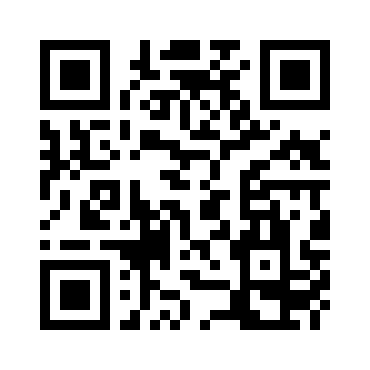

In [32]:
qrcode.make('https://gitlab.com/Vodolagin/ShortFunML')

In [1]:
import itertools
from copy import deepcopy
from itertools import product  # some useful functions

import matplotlib.pyplot as plt
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import scipy
import scipy.stats as scs
import seaborn as sns  # more plots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from dateutil.relativedelta import \
    relativedelta  # working with dates with style
from openpyxl import load_workbook
from scipy.optimize import minimize  # for function minimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              GradientBoostingRegressor,
                              RandomForestClassifier, RandomForestRegressor,
                              VotingRegressor)
from sklearn.feature_selection import (RFECV, GenericUnivariateSelect,
                                       SelectFromModel)
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook

# %run "Initialize notebooks.ipynb"

In [ ]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict()

In [ ]:
root_dir = r'D:\Users\Karganak\Downloads'
all_paths = glob.glob(os.path.join(root_dir, '*'))
files = [f for f in all_paths if os.path.isfile(f)]
all_paths_including_sub = glob.glob(os.path.join(root_dir, '**/*'), recursive=True)
files_including_sub = [f for f in all_paths_including_sub if os.path.isfile(f)]

In [ ]:
def collect_info_file(filename):
    features = {}
#     features['name'] = os.path.basename(filename).split('.')[0]  # Cheating, also I'm paranoid =)
    paths_nearby = os.listdir(os.path.dirname(filename))
    features['paths_nearby'] = len(paths_nearby)
    files_nearby = [f for f in paths_nearby if os.path.isfile(f)]
    features['files_nearby'] = len(files_nearby)
    dirs_nearby = [f for f in paths_nearby if os.path.isdir(f)]
    features['dirs_nearby'] = len(dirs_nearby)
    if '.' in filename:
        features['extension'] = filename.split('.')[-1]
        same_extension_nearby = [f for f in files_nearby if (('.' in f) and (f.split('.')[-1] == features['extension']))]
    else:
        features['extension'] = ''
        same_extension_nearby = [f for f in files_nearby if '.' not in f]
    features['same_extension_nearby'] = len(same_extension_nearby)
    os_stat = os.stat(filename)
    features['mode'] = os_stat.st_mode
    features['size'] = os_stat.st_size / 2**20
    features['accessed_time'] = pd.to_datetime(os_stat.st_atime*10**9)
    features['modified_time'] = pd.to_datetime(os_stat.st_mtime*10**9)
    features['created_time'] = pd.to_datetime(os_stat.st_ctime*10**9)
    return features

In [33]:
# df = pd.concat([pd.Series(collect_info_file(f)) for f in files_including_sub], axis = 1).T
df = pd.read_csv('./data_cleaned.csv', index_col=0, parse_dates=[8, 9, 10])

In [118]:
def define_additional_features(df):
    df['time_since_accessed'] = pd.datetime.now() - df['accessed_time']
    df['time_since_modified'] = pd.datetime.now() - df['modified_time']
    df['time_since_created'] = pd.datetime.now() - df['created_time']
    df['time_modified_created'] = df['modified_time'] - df['created_time']
    
    df = pd.concat([df, pd.get_dummies(df['extension'], prefix='ext')], sort=False, axis=1).drop(columns='extension')
    
    for c in ['accessed_time', 'modified_time', 'created_time']:
        df[c] = (df[c] - df[c].min())/pd.Timedelta('1D')
        
    return df
    

In [52]:
pd.get_dummies(df['extension'], prefix='ext').head()

ext_  ext_0  ext_1  ext_2  ext_3  ext_55  ext_57  ext_6  ext_62  ext_7  \
0     0      0      0      0      0       0       0      0       0      0   
1     0      0      0      0      0       0       0      0       0      0   
2     0      0      0      0      0       0       0      0       0      0   
3     0      0      0      0      0       0       0      0       0      0   
4     0      0      0      0      0       0       0      0       0      0   

   ...  ext_wolf  ext_wow  ext_xbm  ext_xcf  ext_xls  ext_xlsx  ext_xml  \
0  ...         0        0        0        0        0         0        0   
1  ...         0        0        0        0        0         0        0   
2  ...         0        0        0        0        0         0        0   
3  ...         0        0        0        0        0         0        0   
4  ...         0        0        0        0        0         0        0   

   ext_z  ext_zip  ext_zipmod  
0      0        0           0  
1      0        0           0  
2      0        0           0  
3      0        0           0  
4      0        0           0  

[5 rows x 162 columns]

In [106]:
all_features = define_additional_features(df)

In [62]:
rule_0 = df['extension'].isin(['gif', 'png', 'jpg', 'jpeg']) & (df['size'] < 0.5)
rule_1 = (df['paths_nearby'] > df['paths_nearby'].quantile(0.9))

In [128]:
rand_index = np.random.choice(all_features.index, 1000, replace=False)
X_train = all_features.loc[rand_index].dropna()
X_test = all_features.loc[set(df.index) - set(rand_index)].dropna()

In [129]:
y_train = rule_0.loc[X_train.index]
y_test = rule_0.loc[X_test.index]

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
prediction = model.predict(X_test)

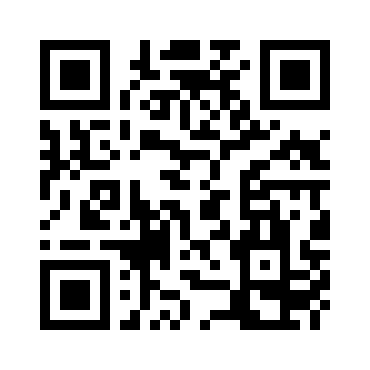